In [24]:
import numpy as np
import pandas as pd
import time
import sys
import os

sys.path.append("../")

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

os.environ["OMP_NUM_THREADS"] = "2"

In [26]:
def preprocessing():
    dataset = pd.read_csv("./data/german_credit_data.csv").drop("Unnamed: 0", axis=1)

    dataset.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

    for column in dataset.columns:
        if dataset[column].dtype != np.dtype("int64"):
            dataset[column] = LabelEncoder().fit_transform(dataset[column])

    return dataset


def train_model(x, y, model):
    cv = KFold(n_splits=3, random_state=None)
    global total_cm
    total_cm = np.zeros((2, 2))
    metric_dict = {}
    split_dict = {}

    it = 0
    for train_ind, test_ind in cv.split(x):
        x_train, x_test = x[train_ind], x[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        total_cm += confusion_matrix(y_test, y_pred)

        metrics = [
            accuracy_score(y_test, y_pred) * 100,
            precision_score(y_test, y_pred) * 100,
            recall_score(y_test, y_pred) * 100,
        ]

        metrics = np.round(metrics, decimals=2)

        metric_dict[it] = metrics
        split_dict[it] = (train_ind, test_ind)
        it += 1

    return total_cm, metric_dict, split_dict

In [27]:
dataset = preprocessing()

model = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=22222)
# model2 = LogisticRegression(max_iter = 1000)

cols = dataset.iloc[:, :-1].columns.values
class_names = ["Bad Risk", "No Risk"]
X = dataset.drop(dataset.columns[-1], axis=1).values
Y = dataset.iloc[:, [-1]].values.reshape(-1,)

cm, metrics, splits = train_model(X, Y, model)

x_train, x_test = X[splits[0][0]], X[splits[0][1]]
y_train, y_test = Y[splits[0][0]], Y[splits[0][1]]

In [28]:
model.predict_proba(x_test)[0]

array([0.92, 0.08])

In [29]:
data_maximums = dataset.iloc[:, :-1].max()

discrete_map = np.where(
    data_maximums < 20, 1, 0
)  # Can use np.where(discrete_map == 1, cols, 0)
continuous_map = np.where(data_maximums > 20, 1, 0)
feature_map = {"continuous": continuous_map, "discrete": discrete_map}

In [30]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def split_by_cm(x, y, model, test_size=0.20, plot_cm=False, class_names=None):
        
    cm_dict_x = {"true_neg":[], "false_neg":[], "true_pos":[], "false_pos":[]}
    cm_dict_y = {"true_neg":[], "false_neg":[], "true_pos":[], "false_pos":[]}
    
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=0, stratify = y
        )

    model.fit(x_train, y_train)
    y_prob = model.predict_proba(x_test)
    y_pred = np.argmax(y_prob, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    
    if class_names == None:
        class_names = np.unique(y_pred)
        
    if plot_cm:
        plt.rcParams['font.size'] = '15'
        fig = ConfusionMatrixDisplay(cm, display_labels=class_names)
        fig.plot(cmap="Greens", colorbar=False, xticks_rotation="horizontal")

    for i in range(x_test.shape[0]):
        #Four cases
        if y_test[i] == 1:
            if y_pred[i] == y_test[i]:
                cm_dict_x["true_pos"].append(x_test[i])
                cm_dict_y["true_pos"].append(y_prob[i])
            else:
                cm_dict_x["false_pos"].append(x_test[i])
                cm_dict_y["false_pos"].append(y_prob[i])

        elif y_test[i] == 0:
            if y_pred[i] == y_test[i]:
                cm_dict_x["true_neg"].append(x_test[i])
                cm_dict_y["true_neg"].append(y_prob[i])
            else:
                cm_dict_x["false_neg"].append(x_test[i])
                cm_dict_y["false_neg"].append(y_prob[i])
        else:
            raise AssertionError

    return {"samples":cm_dict_x, "prob":cm_dict_y}

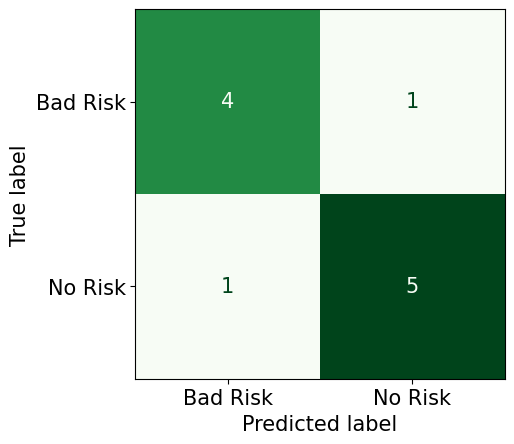

In [31]:
splits = split_by_cm(X, Y, model, test_size=0.02, plot_cm=True, class_names=class_names)

In [32]:
from chweimo.counterfactual import Optimizer

explainer = Optimizer(X, Y, model.predict_proba, col_names=cols)

x_orig = x_test[0]
x_orig_y = model.predict_proba(x_orig.reshape(1, -1)).reshape(-1)
change_class = np.argmin(x_orig_y)

explainer.generate_cf(
            sample=x_orig,
            change_class=change_class,
            termination=1,
            verbose=False,
            plausible=False,
            use_MAD=False,
            pop_size=5
        )

In [66]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)
from chweimo.explain_tools.change import find_changes, consolidate_agg_change
from chweimo.explain_tools.linear_model import find_weight, consolidate_agg_weight
from chweimo.explain_tools.plot import plot_weight, plot_change
from tqdm import tqdm
from datetime import date

def design_title(type_name, fig_context, data_name, section):
    return "{d} - {t}{f} - {s}".format(d=data_name,
                                           t=type_name,
                                           s=section,
                                           f=fig_context)
    
def figure_designer(fig, ax, type_name, fig_context, plausible, data_name, section):
    pad = 25 if plausible else 0
    title = design_title(type_name, fig_context, data_name, section)
    ax.set_title(title, pad=pad)
    
    if plausible:
        fig.text(.5, 0.98, "Plausible Results", ha="center")
        
    fig.savefig("{d}{t}.png".format(d=date.today(), t=title), bbox_inches="tight")
    
    return fig

def perform_aggregation(explainer, cm_splits, type_dict, use_MAD=True, plausible=True, data_name="", **kwargs):
    # -explainer is reused for its settings
    for section in cm_splits["samples"]: #true_neg, false_neg, etc.
        change_agg = []
        weight_agg = []
        
        for i, sample in tqdm(enumerate(cm_splits["samples"][section])):
            sample_y = cm_splits["prob"][section][i]
            
            change_class = np.argmin(sample_y)
            
            explainer.generate_cf(
                sample=x_orig,
                change_class=change_class,
                plausible=plausible,
                use_MAD=use_MAD,
                **kwargs
            )
            
            change = find_changes(explainer)
            weight = find_weight(explainer)
            change_agg.append(change)
            weight_agg.append(weight)
            
        
        merged_change = consolidate_agg_change(change_agg)
        merged_weight = consolidate_agg_weight(weight_agg)
        """
        fig, ax = plot_change(merged_change, type_dict, "continuous", explainer.col_names_)
        figure_designer(fig, ax, "Continuous ", "Change Medians", plausible, data_name, section)
            
        fig, ax = plot_change(merged_change, type_dict, "discrete", explainer.col_names_)
        figure_designer(fig, ax, "Discrete ", "Change Medians", plausible, data_name, section)
            
        fig, ax = plot_weight(merged_weight, explainer.col_names_)
        figure_designer(fig, ax, "", "Feature Weights", plausible, data_name, section)
        """
        break

        
    return merged_change

4it [00:17,  4.48s/it]


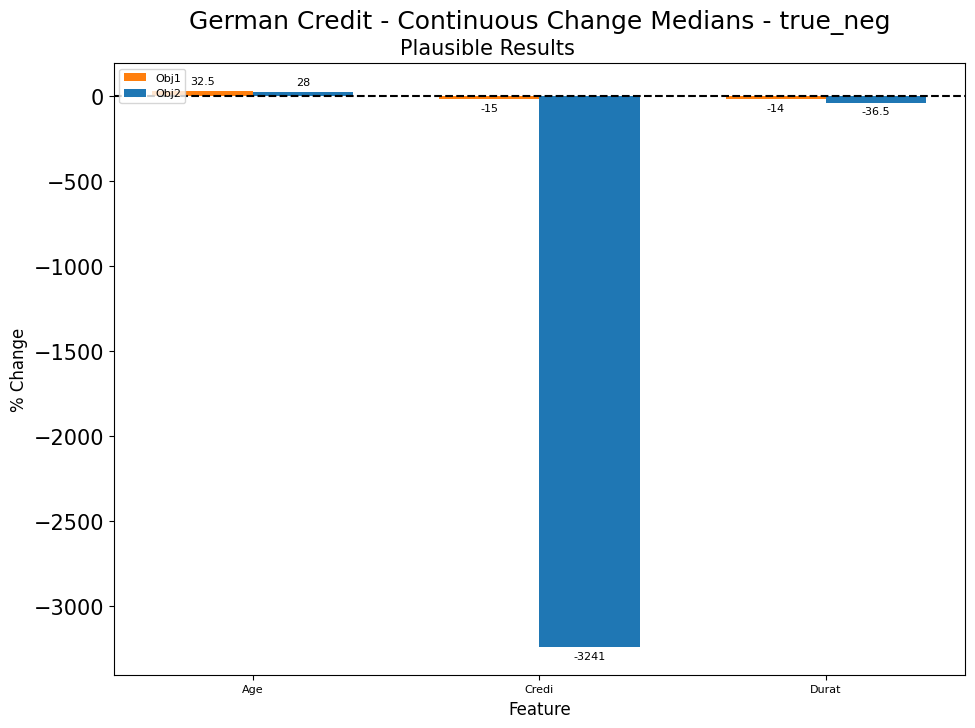

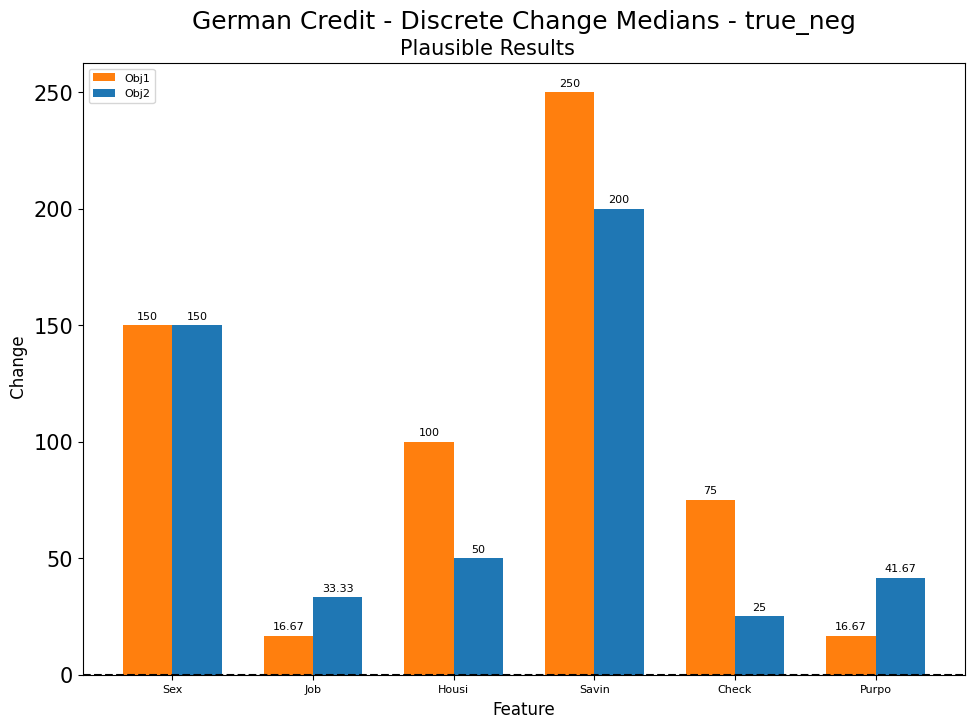

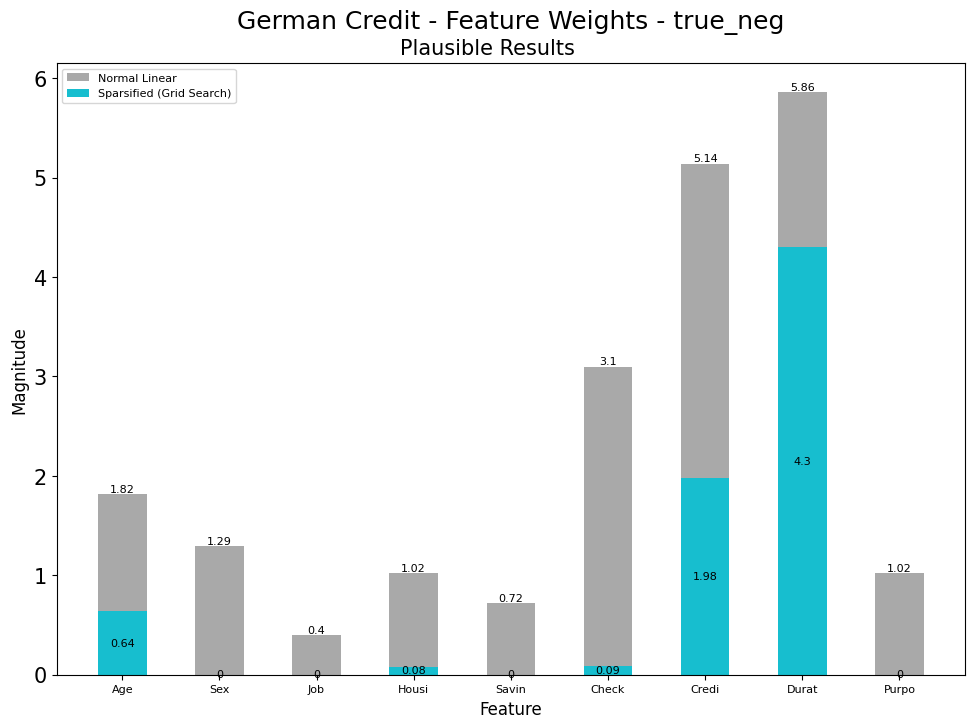

In [67]:
test = perform_aggregation(explainer, splits,
                           type_dict=feature_map, termination=10, verbose=False, pop_size=40,
                           data_name="German Credit")